In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
import numpy as np
import xarray as xr
from ftplib import FTP
import urllib
import pandas as pd
import scipy.interpolate as interp

In [2]:
from distributed import Client

In [3]:
client = Client()

In [4]:
client

Client Scheduler: tcp://127.0.0.1:41093 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 4 Memory: 8.27 GB


# Real Iceberg

In [5]:
year = 2015 # 2002 through 2015 available
iip_url_base = 'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G00807/' 
iip_filename = 'IIP_{}IcebergSeason.csv'.format(year)
iip_url = iip_url_base + iip_filename

In [6]:
r = urllib.request.urlretrieve(iip_url)
df = pd.read_csv(r[0])

In [7]:
n = df.BERG_NUMBER.mode()[0]

In [8]:
real_berg = df.loc[df['BERG_NUMBER'] == n]

In [9]:
real_berg_track = real_berg.loc[6318:6333]

In [10]:
some_dates = real_berg_track.DATE + ' ' + real_berg_track.TIME.astype(str)
pd.to_datetime(some_dates)

6318   2015-06-15 11:13:00
6319   2015-06-16 14:42:00
6320   2015-06-17 13:00:00
6321   2015-06-18 12:49:00
6322   2015-06-19 11:33:00
6323   2015-06-21 10:45:00
6324   2015-06-21 19:03:00
6325   2015-06-22 11:01:00
6326   2015-06-25 11:18:00
6327   2015-06-25 19:08:00
6328   2015-06-26 10:46:00
6329   2015-06-26 16:51:00
6330   2015-06-27 13:31:00
6331   2015-06-28 10:10:00
6332   2015-06-30 10:52:00
6333   2015-06-30 17:30:00
dtype: datetime64[ns]

In [11]:
real_berg_track['time'] = pd.to_datetime(some_dates)

/home/evankielley/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
real_berg_track

,ICE-YEAR,BERG_NUMBER,DATE,TIME,LATITUDE,LONGITUDE,METHOD,SIZE,SHAPE,SOURCE,time
6318,2015,21511,6/15/2015,1113,48.49,-50.14,R/V,LG,GEN,GTJZ,2015-06-15 11:13:00
6319,2015,21511,6/16/2015,1442,48.16,-50.01,R/V,LG,TAB,GTJZ,2015-06-16 14:42:00
6320,2015,21511,6/17/2015,1300,48.09,-50.02,R/V,LG,GEN,GMRS,2015-06-17 13:00:00
6321,2015,21511,6/18/2015,1249,48.08,-49.76,VIS,LG,TAB,GTJZ,2015-06-18 12:49:00
6322,2015,21511,6/19/2015,1133,48.00,-49.65,R/V,LG,TAB,GPGR,2015-06-19 11:33:00
6323,2015,21511,6/21/2015,1045,47.96,-49.54,VIS,LG,TAB,GPGR,2015-06-21 10:45:00
6324,2015,21511,6/21/2015,1903,47.92,-49.50,R/V,LG,TAB,SHIP,2015-06-21 19:03:00
6325,2015,21511,6/22/2015,1101,47.87,-49.45,R/V,LG,TAB,GTJZ,2015-06-22 11:01:00
6326,2015,21511,6/25/2015,1118,47.56,-49.41,R/V,LG,GEN,GTJZ,2015-06-25 11:18:00
6327,2015,21511,6/25/2015,1908,47.51,-49.44,R/V,LG,GEN,GPGR,2015-06-25 19:08:00


# Input Fields

## Ocean (GLBv0.08)

- 3 hr
- 0.08 degree

In [13]:
glb_url = 'http://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_56.3'

In [14]:
glb_ds = xr.open_dataset(glb_url, decode_times=False)

In [15]:
# June 1, 00:00 = 135120., July 1, 00:00 = 135840.
glb_ds = glb_ds.sel(depth=0.0, lat = slice(45., 51.), lon = slice(-53., -47.), time=slice(135120., 135840.))

In [16]:
water_u_data = glb_ds.water_u
water_v_data = glb_ds.water_v
water_temp_data = glb_ds.water_temp

In [18]:
water_u_data.time

<xarray.DataArray 'time' (time: 236)>
array([ 135120.,  135123.,  135126., ...,  135834.,  135837.,  135840.])
Coordinates:
    depth    float64 0.0
  * time     (time) float64 1.351e+05 1.351e+05 1.351e+05 1.351e+05 ...
Attributes:
    long_name:    Valid Time
    units:        hours since 2000-01-01 00:00:00
    time_origin:  2000-01-01 00:00:00
    calendar:     gregorian
    axis:         T
    NAVO_code:    13

In [22]:
glb_times = np.asarray(water_u_data.time)
glb_lats = np.asarray(water_u_data.lat)
glb_lons = np.asarray(water_u_data.lon)

In [23]:
glb_times = glb_times - 135120

#### Warning -- the box below takes a few minutes to run

In [24]:
water_u = np.asarray(water_u_data)
water_v = np.asarray(water_v_data)
water_temp = np.asarray(water_temp_data)

In [25]:
water_u_interp = interp.RegularGridInterpolator((glb_times, glb_lats, glb_lons), water_u)
water_v_interp = interp.RegularGridInterpolator((glb_times, glb_lats, glb_lons), water_v)
water_temp_interp = interp.RegularGridInterpolator((glb_times, glb_lats, glb_lons), water_temp)

## Atmosphere (NAVGEM)

- 6 hr
- 0.5 degree

In [26]:
navgem_url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdNavgem05D10mWind_LonPM180'

In [27]:
navgem_ds = xr.open_dataset(navgem_url)

In [28]:
navgem_ds = navgem_ds.sel(time=slice('2015-06-01','2015-07-01'), latitude=slice(45,51), longitude=slice(-53,-47))

In [29]:
wind_u = navgem_ds.wnd_ucmp_height_above_ground
wind_v = navgem_ds.wnd_vcmp_height_above_ground

In [30]:
navgem_times = np.linspace(0, 120*6 - 6, 120)
navgem_lats = np.asarray(wind_u.latitude)
navgem_lons = np.asarray(wind_u.longitude)

In [32]:
wind_u = np.asarray(wind_u[:,0,:,:])
wind_v = np.asarray(wind_v[:,0,:,:])

In [33]:
wind_u_interp = interp.RegularGridInterpolator((navgem_times, navgem_lats, navgem_lons), wind_u)
wind_v_interp = interp.RegularGridInterpolator((navgem_times, navgem_lats, navgem_lons), wind_v)

# Model

In [34]:
import scipy.io as sio
import numpy.matlib
import cmath

In [35]:
# Constants
R = 6378*1e3
om = 7.2921e-5
rhow = 1027
rhoa = 1.2
rhoi = 850
drho = rhow - rhoi
Cw = 0.9
Ca = 1.3
gam = np.sqrt(rhoa*drho/rhow/rhoi*(Ca/Cw))
sst0 = -4
Cs1 = 1.5; Cs2 = 0.5; Cs3 = 0.1
CMv1 = 7.62e-3; CMv2 = 1.29e-3; CMe1 = 0.5
CMb1 = 0.58; CMb2 = 0.8; CMb3 = 0.2

In [36]:
# Timesteps
t0 = 360  # initial hour
t_inc = 1  # 3 hr
num_days = 15
tn = t_inc*num_days*24  # total number of timesteps
dt = t_inc*3600  # model timestep in seconds
tf = t0 + tn*dt  # final timestep in seconds  
t_all = np.arange(t0, t0+tn, t_inc)

In [37]:
# Iceberg Inits
x0, y0 = -50.14, 48.49   # lon, lat

# Large berg: 
    # Height: 46 metres to 75 metres above surface 
    # Length or width: 121 metres to 200 metres
    
l0 = (121 + 200)/2
w0 = (121 + 200)/2
h0 = ((46 + 75)/2)*10


timestep: 360

vau =  4.50289006958
vav =  -4.64879910737
vwu =  0.120254498954
vwv =  -0.211447684073
sst =  5.16779239501
S = 252.112810450580895
ff = 0.000109212332084
lam = 5.608740659580275
alpha = -0.244256661240217
0.953443948885
beta = 0.9534439488846986
viu = 0.179453062505700
viv = -0.315160694814071
x_new = -50.131244163987510
y_new = 48.479807688985183
Me = 2.231618098111216
Mv = 0.073829418976867
Mb = 0.351767753237082
rollover
swap l and w
l_new = 604.985343010281781
w_new = 160.403939686787993
h_new = 160.403939686787993

timestep: 361

vau =  4.50153313319
vav =  -3.74575333831
vwu =  0.137496249229
vwv =  -0.211871130118
sst =  5.16122715224
S = 398.315658703703320
ff = 0.000109195136120
lam = 3.212712517381467
alpha = -0.399606080844007
0.864934925117
beta = 0.8649349251173031
viu = 0.182427448640231
viv = -0.306331394865190
x_new = -50.122344965554291
y_new = 48.469900917926971
Me = 2.107768336391465
Mv = 0.073691913674962
Mb = 0.242473500618186
l_new = 604.89444883

lam = 5.944368028372402
alpha = -0.231270560256171
0.95844361047
beta = 0.9584436104698713
viu = 0.781123367813279
viv = -0.123660706246350
x_new = -48.686180589927361
y_new = 48.240404316381785
Me = 2.931273772197891
Mv = 0.068531456263847
Mb = 0.383424044726188
l_new = 597.165486047705713
w_new = 152.584082724211726
h_new = 159.387617974448744

timestep: 425

vau =  9.93199068062
vav =  2.95069727517
vwu =  0.625754452473
vwv =  -0.203352131336
sst =  4.95544063422
S = 381.801454416866704
ff = 0.000108790233959
lam = 5.952044452474569
alpha = -0.230989131350542
0.958548453471
beta = 0.9585484534712442
viu = 0.817009505808174
viv = -0.193337373279217
x_new = -48.646510548593717
y_new = 48.234151777052880
Me = 2.932193928866058
Mv = 0.069438203157032
Mb = 0.385533407620624
l_new = 597.040418042204806
w_new = 152.459014718710762
h_new = 159.371554082464542

timestep: 426

vau =  9.81395178145
vav =  3.39952876243
vwu =  0.655310731501
vwv =  -0.277904650346
sst =  5.00742329106
S = 381.

x_new = -48.011530138606361
y_new = 48.186417145067381
Me = 2.589821842225478
Mv = 0.078281818524529
Mb = 0.339314674426257
l_new = 593.057975433716138
w_new = 148.476572110221809
h_new = 158.887487705574841

timestep: 464

vau =  -6.45445445095
vav =  4.70785656816
vwu =  0.0163370993101
vwv =  0.0168527390306
sst =  5.36540251819
S = 373.055602428378108
ff = 0.000108698662922
lam = 4.700936518787629
alpha = -0.287531158826008
0.934397042278
beta = 0.9343970422780356
viu = -0.071349757878970
viv = 0.134113002497740
x_new = -48.014991245917315
y_new = 48.190754365587203
Me = 2.519308858624949
Mv = 0.078020299183575
Mb = 0.325699019172330
l_new = 592.949753385474082
w_new = 148.368350061979783
h_new = 158.873916913109326

timestep: 465

vau =  -5.98638586275
vav =  4.70109626037
vwu =  -0.00681294173927
vwv =  0.0655752848183
sst =  5.35246129958
S = 372.824484976789790
ff = 0.000108706023121
lam = 4.481371252009597
alpha = -0.300253227523484
0.928058634547
beta = 0.9280586345471012
viu

l_new = 587.215627553605373
w_new = 142.634224230111101
h_new = 158.167378231359777

timestep: 519

vau =  5.16506661005
vav =  0.297877291759
vwu =  0.161446295203
vwv =  -0.170352951427
sst =  5.36136671662
S = 360.526919558428744
ff = 0.000108165741954
lam = 3.165629102754622
alpha = -0.404379407675070
0.861194199043
beta = 0.8611941990426304
viu = 0.247093719638476
viv = -0.204699733194594
x_new = -47.300291940562978
y_new = 47.866725199095356
Me = 1.964606704453712
Mv = 0.077933700840966
Mb = 0.225468211457544
l_new = 587.130521703384716
w_new = 142.549118379890501
h_new = 158.157983722549034

timestep: 520

vau =  5.09935453633
vav =  0.249200357778
vwu =  0.164874888138
vwv =  -0.191856821961
sst =  5.40092523859
S = 360.343620244144518
ff = 0.000108154438261
lam = 3.125809399200747
alpha = -0.408489609460501
0.857912041408
beta = 0.8579120414084078
viu = 0.248797819439785
viv = -0.226899587574296
x_new = -47.288298984982042
y_new = 47.859387256249860
Me = 1.949913553155975
Mv =


vau =  6.62792186875
vav =  -5.44307955242
vwu =  0.0759584354998
vwv =  -0.256722071763
sst =  5.23216255651
S = 351.108772924265509
ff = 0.000107357785510
lam = 5.429073164130922
alpha = -0.251801152075747
0.950391654554
beta = 0.9503916545536207
viu = 0.168354181715005
viv = -0.384988949467231
x_new = -47.184350893108046
y_new = 47.389821268603640
Me = 2.625250804395709
Mv = 0.075183505953542
Mb = 0.342547783421360
l_new = 582.744249764164124
w_new = 138.162846440669938
h_new = 157.628235795855602

timestep: 566

vau =  6.59584963113
vav =  -5.31666227076
vwu =  0.0998542470841
vwv =  -0.24497801099
sst =  5.28482669888
S = 350.864832787407181
ff = 0.000107336332386
lam = 5.367620777269747
alpha = -0.254485164581442
0.949279158518
beta = 0.9492791585177989
viu = 0.191870233988879
viv = -0.371062109794390
x_new = -47.175186455847317
y_new = 47.377821103319476
Me = 2.606574507945857
Mv = 0.076299296721349
Mb = 0.341041039794735
l_new = 582.632463355636332
w_new = 138.051060032142146


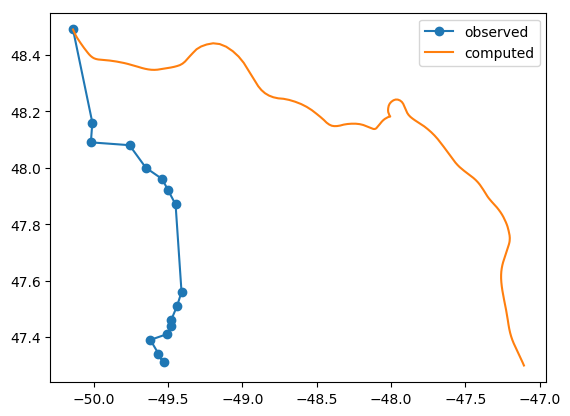

In [38]:
def main():

    x, y = x0, y0
    l, w, h = l0, w0, h0
    t = t0
    iceberg = np.array([[t0],[x0],[y0],[l0],[w0],[h0]])

    while t < max(t_all):

        x_new, y_new, l_new, w_new, h_new = iceDEF(t, x, y, l, w, h)

        
        if x_new > -47.1 or x_new < -53 or y_new > 51 or y_new < 45:
            # Iceberg out-of-bounds
            print(x_new)
            print(y_new)
            print('out-of-bounds')
            break
        

        if l_new <= 0 or w_new <= 0 or h_new <= 0:
            # Iceberg melted
            print('melted')
            break

        else:
            x, y, l, w, h = x_new, y_new, l_new, w_new, h_new
            t += t_inc
            iceberg_new = np.array([[t],[x],[y],[l],[w],[h]])
            iceberg = np.column_stack((iceberg, iceberg_new))

    plt.plot(real_berg_track['LONGITUDE'], real_berg_track['LATITUDE'], label='observed', marker='o')        
    plt.plot(iceberg[1,:],iceberg[2,:], label='computed')
    plt.legend()

        
    save_dict = {
                    't_arr': iceberg[0,:],
                    'x_arr': iceberg[1,:],
                    'y_arr': iceberg[2,:],
                    'l_arr': iceberg[3,:],
                    'w_arr': iceberg[4,:],
                    'h_arr': iceberg[5,:]
                }

    

def iceDEF(t,x,y,l,w,h):

    print('\ntimestep: {}\n'.format(t))
    

    # Extract values from input fields
    
    vau = wind_u_interp([t, y, x])[0]
    vav = wind_v_interp([t, y, x])[0]  
    vwu = water_u_interp([t, y, x])[0] 
    vwv = water_v_interp([t, y, x])[0]
    sst = water_temp_interp([t, y, x])[0]

    print('vau = ', vau)
    print('vav = ', vav)
    print('vwu = ', vwu)
    print('vwv = ', vwv)
    print('sst = ', sst)
    

    # Drifting

    S = np.pi*((l*w)/(l+w))
    ff = 2*om*np.sin((np.abs(y)*np.pi)/180)
    lam = np.sqrt(2)*Cw*(gam*np.sqrt(vau**2 + vav**2))/(ff*S)
    print('S = {0:.15f}'.format(S))
    print('ff = {0:.15f}'.format(ff))
    print('lam = {0:.15f}'.format(lam))
    
    if lam < 0.1:
        print('Taylor approx used for alpha')
        alpha = lam*(lam**4*(lam**4*(lam**4*(-0.0386699020961393*lam**4 + \
            0.055242717280199) - 0.0883883476483184) + \
            0.176776695296637) - 0.707106781186548)
    else:
        alpha = np.multiply(np.divide(np.sqrt(2),np.power(lam, 3)),(1-np.sqrt(1+np.power(lam,4))))
        
    if lam < 0.6:
        print('Taylor approx used for beta')
        beta = lam**3*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*\
            (0.0153268598203613*lam**4 - 0.0151656272365985) + \
            0.0180267866272764) + 0.0219176256311202) - \
            0.0274446790511418) + 0.0357675015202851) - \
            0.0493731785691779) + 0.0745776683282687) - \
            0.132582521472478) + 0.353553390593274)
    else:
        beta = np.real(np.multiply(np.divide(1.,np.power(lam,3.)),cmath.sqrt(np.multiply((4.+np.power(lam,4.)), \
            cmath.sqrt(1.+np.power(lam,4.)))-3.*np.power(lam,4.)-4.)))

    print('alpha = {0:.15f}'.format(alpha))
    print(beta)
    print('beta = {}'.format(beta))

    viu = vwu + gam*(-alpha*vav + beta*vau)
    viv = vwv + gam*(alpha*vau + beta*vav)

    print('viu = {0:.15f}'.format(viu))
    print('viv = {0:.15f}'.format(viv))

    y_new = y + (viv*dt)*(180/(np.pi*R))
    x_new = x + (viu*dt)/(np.cos((((y + y_new)/2)*np.pi)/180))*(180/(np.pi*R))

    print('x_new = {0:.15f}'.format(x_new))
    print('y_new = {0:.15f}'.format(y_new))
    
    
    # Melting

    Me = CMe1*(Cs1*np.sqrt(vau**2 + vav**2)**Cs2 + Cs3*np.sqrt(vau**2 + vav**2))
    Mv = CMv1*sst + CMv2*sst**2
    Mb = CMb1*np.power(np.sqrt(np.square(viu-vwu)+np.square(viv-vwv)),CMb2)*(sst - sst0)/l**CMb3

    print('Me = {0:.15f}'.format(Me))
    print('Mv = {0:.15f}'.format(Mv))
    print('Mb = {0:.15f}'.format(Mb))

    l_new = l - (Mv + Me)*(dt/(24*3600))  # convert dt from secs to days
    w_new = w - (Mv + Me)*(dt/(24*3600))
    h_new = h - Mb*(dt/(24*3600))

    if w_new < 0.85*h_new:
        # Rollover
        print('rollover')
        w_new, h_new = h_new, w_new

    if w_new > l_new:
        # Ensure l is greater than w
        print('swap l and w')
        w_new, l_new = l_new, w_new

    print('l_new = {0:.15f}'.format(l_new))
    print('w_new = {0:.15f}'.format(w_new))
    print('h_new = {0:.15f}'.format(h_new))

    return x_new, y_new, l_new, w_new, h_new    


if __name__=="__main__":
    main()

In [39]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

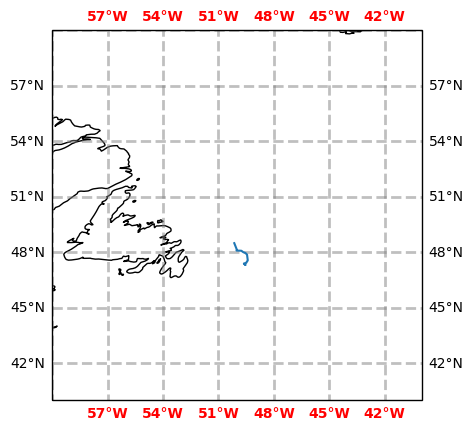

In [40]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-40, -60, 40, 60], ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines('50m')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
#gl.xlabels_top = False
#gl.ylabels_left = False
#gl.xlines = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
ax.plot(real_berg_track['LONGITUDE'], real_berg_track['LATITUDE'])
plt.show()

In [41]:
from matplotlib.animation import FuncAnimation

In [42]:
from IPython.display import HTML

In [43]:
water_mag = np.sqrt(water_u**2 + water_v**2)

In [44]:
real_berg_track['LONGITUDE'], real_berg_track['LATITUDE']

(6318   -50.14
 6319   -50.01
 6320   -50.02
 6321   -49.76
 6322   -49.65
 6323   -49.54
 6324   -49.50
 6325   -49.45
 6326   -49.41
 6327   -49.44
 6328   -49.48
 6329   -49.48
 6330   -49.51
 6331   -49.62
 6332   -49.53
 6333   -49.57
 Name: LONGITUDE, dtype: float64, 6318    48.49
 6319    48.16
 6320    48.09
 6321    48.08
 6322    48.00
 6323    47.96
 6324    47.92
 6325    47.87
 6326    47.56
 6327    47.51
 6328    47.46
 6329    47.44
 6330    47.41
 6331    47.39
 6332    47.31
 6333    47.34
 Name: LATITUDE, dtype: float64)

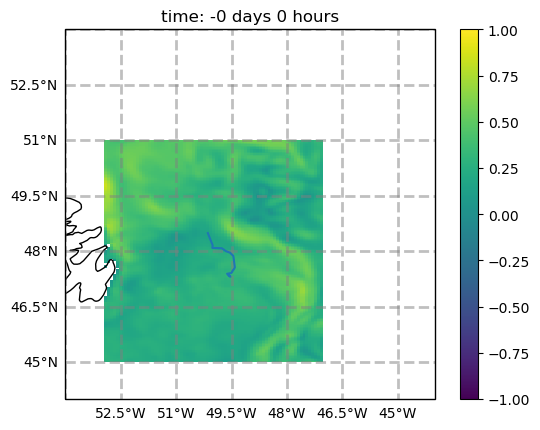

In [49]:
#fig, ax = plt.subplots()

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-54, -44, 44, 54], ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines('50m')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
#gl.xlines = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'size': 15, 'color': 'gray'}
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
ax.plot(real_berg_track['LONGITUDE'], real_berg_track['LATITUDE'])

line, = plt.plot(0,0.5,'o')
im = plt.imshow(water_mag[0,:,:], extent=[glb_lons[0], glb_lons[-1], glb_lats[0], glb_lats[-1]],
                origin = 'lower', vmin = -1, vmax = 1)
plt.colorbar()
title = plt.title('')
def animate(i):
    #line.set_ydata(i)
    #return line
    im.set_data(water_mag[i,:,:])
    time = glb_times[i]
    days = time//24
    hours = time%24
    title.set_text('time: {:.0f} days {:.0f} hours'.format(days, hours))
    return im, title
anim = FuncAnimation(fig, animate, frames=100)

In [50]:
HTML(anim.to_html5_video())